# Model stacking

This notebook will show how modelstacking can be implemented in scikit learn. The notebook will specifically focus on
multiclass data

## Exploring the data

- Checking out the samount of samples in each class
- Transforming the high dimensional data onto 2D space (with t-sne) for viasualization purposes.

Amount of samples in each class: Counter({'BC': 123, 'LU': 56, 'KI': 50})
The shape of the data is: (229, 598)


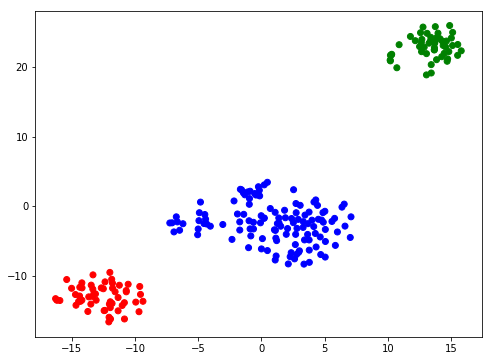

In [1]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore")

############## Loading the data ############
npz = np.load("Data.npz")
#print(npz.files)
X = npz['X']
y = npz['y']
npz.close()


############## Checking the amount of samples in each class #############
from collections import Counter
print('Amount of samples in each class: {0}'.format(Counter(y)))
print('The shape of the data is: {0}'.format(X.shape))


############# Transforming the data onto 2 dimensions with t-sne  ###########
from sklearn.manifold import TSNE
#X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=2).fit_transform(X)


#### Plot the data
plt.figure(figsize=((8,6)))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=list(map(lambda x: 'b' if x=='BC' else 'g' if x=='KI' else 'r' ,y)))
plt.show()

### Creating a class for Model stacking

The class will take a parameter (*Base_Classifiers*) which represents the base classifiers. The metaclassifier will use  majority voting with computed *weights* for each base classifier. The weights will be computed by using non negative  least squares. <br/>

Let $m$ be the number of base classifiers and $n$ number of samples. $f^{-j}_i(x) \in R^K$ for $i=1,...,m$ and $j= 1,...,n$ be the prediction vector of base classifier $i$ for $\textbf{x}$ built on the whole dataset excluding observation $j$. Each prediction will be remapped into a numeric vector of size K (i.e The class 'BC' will be remapped to [1,0,0]). This is done so the problem can be reformulated into nonnegative least squares which will compute the *weight w* vector. This *weight w* vector will show how much each base classifier contributes in the metaclassifier for the final prediction. <br/>

\begin{equation}
\hat{w} = arg \min_{\textbf{w}} = || B\textbf{x} - \textbf{y}||^{2}_{2} \quad \text{subject to } \textbf{w} \geq 0, \quad w_1 +... + w_m = 1 \\
\end{equation}

\begin{equation}
y =\begin{bmatrix}
 \textbf{y}_1\\ 
 \textbf{y}_2\\ 
\vdots\\ 
 \textbf{y}_n
\end{bmatrix} \in R^{Kn \times1}, 
\quad B = \begin{bmatrix}
f^{-1}_1(x_1) & ... & f^{-1}_m(x_1) \\ 
f^{-2}_1(x_2) & ... & f^{-2}_m(x_2) \\ 
 \vdots &  &  \vdots \\ 
f^{-n}_1(x_n) & ... & f^{-n}_m(x_n) \\ 
\end{bmatrix} \in R^{Kn \times m}
\end{equation}

Solving for the *weights w* can be done with quadratic programming [1]

\begin{equation}
arg \min_{w} \bigg(\frac{1}{2} \textbf{w}^TP \textbf{w} + q^T\textbf{w}\bigg) \quad \text{subject to } \textbf{w} \geq 0
\end{equation}

Where

\begin{equation}
P = B^TB, \quad q = -B^T\textbf{y}
\end{equation}

Matrix **P** is positive semi-definite making the problem convex (The solution will be the global minimum)

In [2]:
import numpy as np
import time

### From sci kit learn
from sklearn import datasets
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.base import BaseEstimator

##
from cvxopt import matrix, solvers


## Set random seed (to get deterministic results)                    
np.random.seed(2019)
Random_state = 2019


 
#####  The class that implements model stacking with non-negative least squares                    
class ModelStacking(BaseEstimator):
    
    def __init__(self, Base_Classifiers):
        self.baseModels = Base_Classifiers
        self.metaClassifier = 'This class attribute will be used later to store a VotingClassifier with computed weights'
     
    def fit(self, X, y):
        
        ######## Encode the class labels into numeric arrays. I.e 'BC' = [1,0,0]
        ########This is done to formulate the constrained linear regression problem
        y_encoded = np.array([list(map(lambda x: np.array([1, 0, 0]) if x=='BC' else np.array([0, 1, 0]) if x=='KI' 
                              else np.array([0, 0, 1]) ,y))]).flatten()
        y_encoded = np.array([y_encoded]).T
        
        
        
        #The following nested for loop will compute matrix B used in the constrined least squares
        predictionsForAllBaseClf = []
        for name,baseClf in self.baseModels:
            predictions_for_a_baseClf = []
            for i in range(len(X)):  # For each sample, train each base classifier (excluding the current sample i) and predict on sample i 
                baseClf.fit(np.delete(X, i, 0),np.delete(y, i, 0))
        
                # The following if branches will convert each prediction from each base classifier into a sequence so it fits the QP optimization problem. 
                #A sequence predicted 1, 0, 0 means that the class 'BC'  is predicted from the base classifier
        
                prediction = baseClf.predict(X[i].reshape(1,-1))[0]
                if 'BC'== prediction:
                    predictions_for_a_baseClf.extend([1,0,0])
                
                elif 'KI'== prediction:
                    predictions_for_a_baseClf.extend([0,1,0])
                
                else:
                     predictions_for_a_baseClf.extend([0,0,1])

            predictionsForAllBaseClf.append(predictions_for_a_baseClf)
                   

        B = np.array(predictionsForAllBaseClf)
        B = B.T
        
        #Check if np.dot(B.T,B) is positive-semidefinite. In theory this should always be the case 
        #print(np.all(np.linalg.eigvals(np.dot(B.T,B)) > 0))  
        
        
        ####### The following code will use quadratic programming to solve for the weights
        P = matrix(np.dot(B.T,B).astype(float))
        q = matrix(-np.dot(B.T,y_encoded).astype(float))
        G = matrix(-np.identity(np.size(B,1)).astype(float))
        h = matrix(np.zeros(np.size(B,1)).astype(float))
        A = matrix(np.ones((1,np.size(B,1))).astype(float))
        b = matrix(1.0)
        sol=solvers.qp(P, q, G, h, A, b)
        print('The estimated weights are \n {0} First element represents baseclf 1, and so on \n '.format(sol['x']))
        
        #### Train the meta classifier using the estimated weights
        self.metaClassifier = VotingClassifier(estimators=list(Baseclfs), voting='hard', weights=list(sol['x']))
        self.metaClassifier.fit(X,y)
        
    def predict(self, X):
        return self.metaClassifier.predict(X)



## Base classifiers

This section will test the base classifiers to get a feel how well they work on their own. A KNN classifier with $k=80$ was purposefully chosen to get a baseclassifier with bad performance (Samples belonging to 'KI' and 'LU' have only around 50 samples each). 

In [3]:
Baseclfs = (('KNN where k = 1',KNeighborsClassifier(n_neighbors=1)),
      ('RF' ,RandomForestClassifier(random_state = 1)),
      ('LDA', LinearDiscriminantAnalysis()),
      ('NB' ,GaussianNB(priors=(0.33, 0.33, 0.34))),
      ('QDA', QuadraticDiscriminantAnalysis()),
      ('KNN where k= 80' ,KNeighborsClassifier(n_neighbors=80)),)




####### Testing each base classifier first before traning and evaluating the metaclassfier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print("3-folded cross validation")
for name, clf in Baseclfs:
    #clf.fit(X_train, y_train)
    scores = model_selection.cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f)  of base classifier %s" 
          % (scores.mean(), scores.std(), name))

3-folded cross validation
Accuracy: 0.99 (+/- 0.01)  of base classifier KNN where k = 1
Accuracy: 0.99 (+/- 0.01)  of base classifier RF
Accuracy: 0.98 (+/- 0.02)  of base classifier LDA
Accuracy: 0.79 (+/- 0.06)  of base classifier NB
Accuracy: 0.57 (+/- 0.11)  of base classifier QDA
Accuracy: 0.50 (+/- 0.00)  of base classifier KNN where k= 80


## Using Modelstacking class

- Test using Modelstacking for the full dataset and half of the data set

In [4]:
################   Test code for the  EnsembleClassifier class   ########################                    
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=Random_state)
    
Model_stacking_clf = ModelStacking(Base_Classifiers = Baseclfs)
Model_stacking_clf.fit(X_train, y_train)

print('The accuracy of the metaclassifier is {0} \n \n \n \n'.format(accuracy_score(y_test, Model_stacking_clf.predict(X_test))))




#############   Testing when downsizing the dataset to half the size  #####################
subSampleIndeces = np.random.choice(len(X), int(len(X)+2/2))  ## len(X)+2/2 is used instead of exactly half size, so that k_neighbours < n_samples 
X_half = X[subSampleIndeces, :]
y_half = y[subSampleIndeces]

X_train, X_test, y_train, y_test = train_test_split(X_half, y_half, test_size=0.30, random_state=Random_state)
    
Model_stacking_clf = ModelStacking(Base_Classifiers = Baseclfs)
Model_stacking_clf.fit(X_train, y_train)

print('The accuracy of the metaclassifier when using only\033[1m half the dataset\033[0;0m {0}'.format(accuracy_score(y_test, Model_stacking_clf.predict(X_test))))



     pcost       dcost       gap    pres   dres
 0: -7.9923e+01 -8.1077e+01  1e+00  1e-17  1e-02
 1: -7.9967e+01 -8.0043e+01  8e-02  1e-16  7e-04
 2: -7.9995e+01 -8.0005e+01  1e-02  2e-16  2e-16
 3: -7.9999e+01 -8.0001e+01  2e-03  6e-17  2e-16
 4: -8.0000e+01 -8.0000e+01  2e-04  1e-16  2e-16
 5: -8.0000e+01 -8.0000e+01  3e-05  2e-16  1e-16
Optimal solution found.
The estimated weights are 
 [ 9.96e-01]
[ 2.87e-03]
[ 9.22e-04]
[ 7.60e-05]
[ 6.08e-05]
[ 6.51e-05]
 First element represents baseclf 1, and so on 
 
The accuracy of the metaclassifier is 1.0 
 
 
 

     pcost       dcost       gap    pres   dres
 0: -8.0480e+01 -8.1520e+01  1e+00  5e-17  1e-02
 1: -8.0491e+01 -8.0519e+01  3e-02  1e-16  2e-04
 2: -8.0499e+01 -8.0501e+01  3e-03  1e-16  3e-06
 3: -8.0500e+01 -8.0500e+01  4e-04  8e-17  1e-16
 4: -8.0500e+01 -8.0500e+01  6e-05  9e-17  1e-16
Optimal solution found.
The estimated weights are 
 [ 4.98e-01]
[ 4.98e-01]
[ 3.23e-03]
[ 2.73e-04]
[ 4.18e-04]
[ 9.24e-05]
 First element re

## Conclusions

- The metaclassifier will never perform worse than the best performing base classifier
- Model stacking is used to reduce bias/variance in each model and getting a more stable predictions

- Less data means higher variance in each base model, hence the weight will be distributed more equally.

## References

[1]  V. Franc, V. Hlav ́aˇc, and M. Navara, “Sequential coordinate-wise algorithmfor the non-negative least squares problem,” inComputer Analysis of Imagesand  Patterns,  A.  Gagalowicz  and  W.  Philips,  Eds.Berlin,  Heidelberg:Springer Berlin Heidelberg, 2005, pp. 407–414